# Fire and Water Type Classifier

In this notebook, I do some data visualization and deep learning with the following [Kaggle dataset of Pokemon images](https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types?datasetId=92703&sortBy=voteCount). This is an annotated notebook that documents data wrangling, figure creating, and model building/evaluating. This data has images of most Pokemon from generations 1 through 7, accompanied by their typing. In this notebook, I will look to do a simple binary image classification that will classify Pokemon as either water or fire type.

## Package Import

I begin by importing libraries necessary for handling the data. 

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
from pathlib import Path
import re
import tensorflow as tf
from tensorflow import keras
from keras import layers
import cv2

## Merging Data

We have access to two folders: one with png files and another that stores information on each Pokemon including their name and type. The goal here is to have all our data in one dataframe so that it is easier to work with down the line.

In [21]:
train_dir = "data/images/images/"
train_path = Path(train_dir)

# Creating a dataframe with the name and filepath of each Pokemon
files = list(train_path.glob("*.png"))
names = [os.path.split(filename)[1] for filename in files]
image_df = pd.concat(
    [pd.Series(names, name="Name"), pd.Series(files, name="Filepath").astype(str)],
    axis=1,
)
image_df["Name"] = image_df["Name"].apply(lambda x: re.sub(r"\.\w+$", "", x))

# Importing label_df
label_df = pd.read_csv("data/pokemon.csv")

# Merging so we have one dataframe with pokemon information and filepath to image
df = image_df.merge(label_df, on="Name")

df.head()

,Name,Filepath,Type1,Type2
0,abomasnow,data\images\images\abomasnow.png,Grass,Ice
1,abra,data\images\images\abra.png,Psychic,NaN
2,absol,data\images\images\absol.png,Dark,NaN
3,accelgor,data\images\images\accelgor.png,Bug,NaN
4,aegislash-blade,data\images\images\aegislash-blade.png,Steel,Ghost


## Initial Visualizations

We will focus on "Type1" as this is the Pokemon's "Primary Type." I am interested in the distribution of primary types in the dataset so I will plot the value counts.

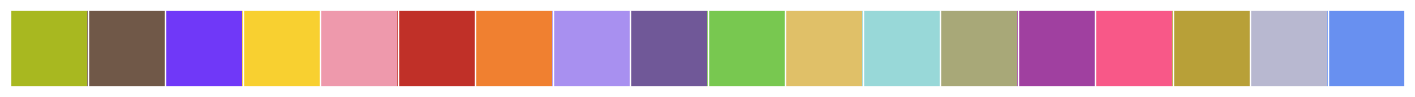

In [22]:
custom_colors = {
    "Bug": "#a8b820",
    "Dark": "#705848",
    "Dragon": "#7038f8",
    "Electric": "#f8d030",
    "Fairy": "#ee99ac",
    "Fighting": "#c03028",
    "Fire": "#f08030",
    "Flying": "#a890f0",
    "Ghost": "#705898",
    "Grass": "#78c850",
    "Ground": "#e0c068",
    "Ice": "#98d8d8",
    "Normal": "#a8a878",
    "Poison": "#a040a0",
    "Psychic": "#f85888",
    "Rock": "#b8a038",
    "Steel": "#b8b8d0",
    "Water": "#6890f0",
}

sns.set(font_scale=1.25)
sns.set_palette(sns.color_palette(custom_colors.values()))
sns.palplot(sns.color_palette(custom_colors.values()), size=1)

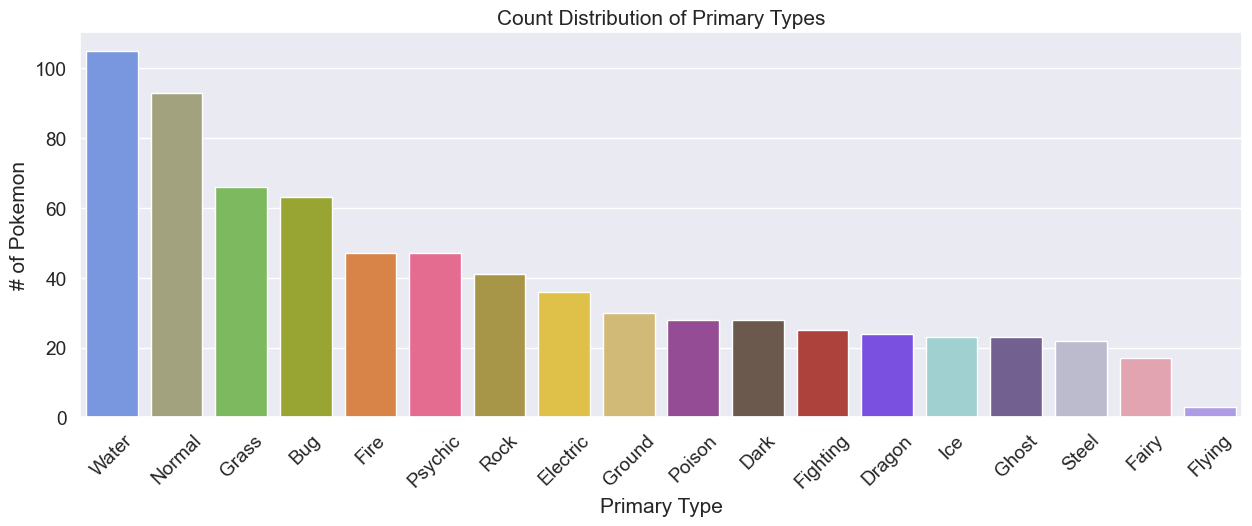

In [23]:
# Find the number of each type of pokemon
type1_data = (
    df["Type1"].value_counts().rename_axis("Type1").reset_index(name="# of Pokemon")
)

# Plot number of each type of pokemon with custom colors
plt.figure(figsize=(15, 5))
plt.title("Count Distribution of Primary Types")
ax = sns.barplot(x="Type1", y="# of Pokemon", data=type1_data, palette=custom_colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
ax.set_xlabel("Primary Type")
plt.show()

We see that the most common primary type is water, followed by normal, grass, bug, and fire. This is good news because it means we will have sufficient data to train our models.

Just to check if we merged the two datasets together properly, I also want to visualize an example of one Pokemon that falls under each primary type.

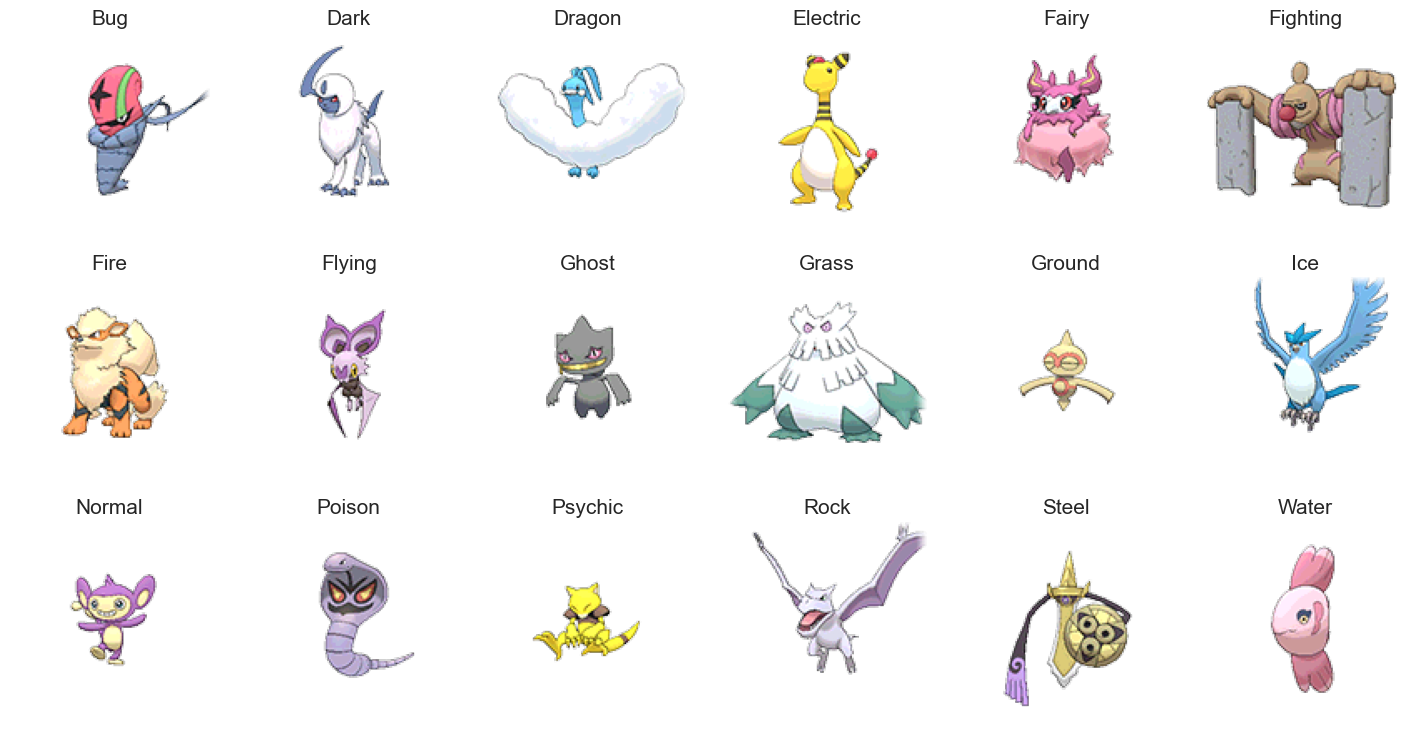

In [24]:
# Getting examples of pokemon of each type
type1 = list(custom_colors.keys())
first_row_indices = []
for type in type1:
    first_row_indices.append(df[df["Type1"] == type].index[0])

# Get images from filepaths
imgs = []
for index in first_row_indices:
    imgs.append(mpimg.imread(df.iat[index, 1]))

# Displaying an example of each pokemon primary type
f, axarr = plt.subplots(3, 6, figsize=(18, 9))
count = 0
for r in range(3):
    for c in range(6):
        axarr[r, c].imshow(imgs[count])
        axarr[r, c].set_title(type1[count])
        axarr[r, c].set_axis_off()
        count += 1

plt.show()

This image gives us a hint at the color palette of each Pokemon type. We see that electric types may be yellow, and ice types are a cool shade of blue. We can also visualize the variance in color that exists among Pokemon that share a type. Consider the example below, which displays many Pokemon that are all fire type. We get a better idea here of the overall color palette inherent to Fire type pokemon (lots of reds, oranges, yellows, etc.).

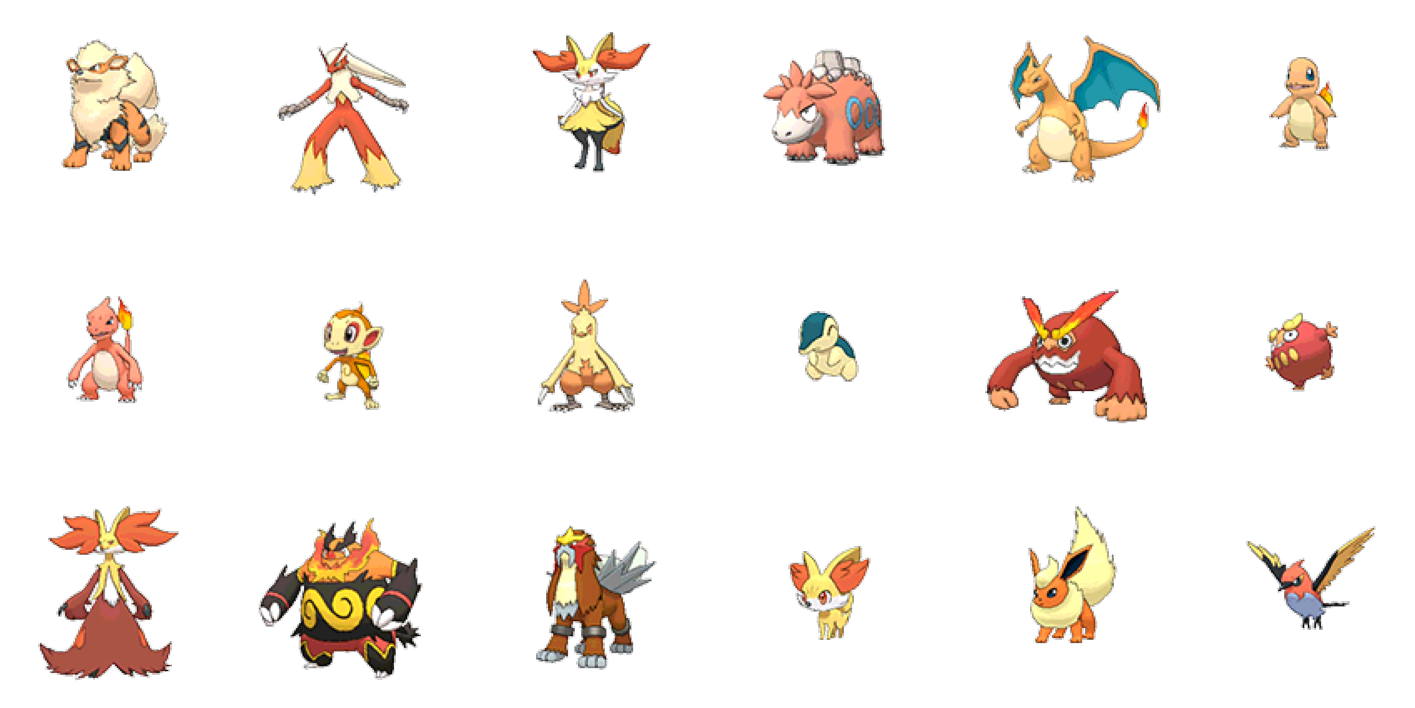

In [25]:
# Showing how appearances change within a single type
water_indices = []
for i in range(len(df.index)):
    if df.iat[i, 2] == "Fire":
        water_indices.append(i)

water_imgs = []
for index in water_indices:
    water_imgs.append(mpimg.imread(df.iat[index, 1]))

f, axarr = plt.subplots(3, 6, figsize=(18, 9))
count = 0
for r in range(3):
    for c in range(6):
        axarr[r, c].imshow(water_imgs[count])
        axarr[r, c].set_axis_off()
        count += 1

plt.show()

## Data Preprocessing

I will be tackling classification of Pokemon types between Fire and Water type Pokemon only. This is a simpler problem, so it should be easier to build a good model.

In [26]:
df = df.query("Type1 == 'Fire' | Type1 == 'Water'")

print("Number of water-types:", len(df[df["Type1"] == "Water"]))
print("Number of fire-types:", len(df[df["Type1"] == "Fire"]))

Number of water-types: 105
Number of fire-types: 47


### Train Test Split

I first shuffle the data before preparing it to be used for training a neural network model using the Keras library. I use `ImageDataGenerator` class from Keras to generate the train-test split. I also rescale the RGB values so that they fit between 0 and 1, effectively normalizing pixel values. I rescale RGB pixel values because keeping them in a smaller range improves numerical stability for computations (NNs are sensitive to input feature scale), lower values may improve convergence speed of optimization algorithms (feature scale impacts speed of gradient-based calculation methods), and many activation functions are more effective when input values have limited range. 

Afterwards, I generate batches of resized image data and note that the labels are binary (it is either "Water" or "Fire"). I then specify the batch size for the training data, which is the number of data points processed in each iteration of the model. To be conscious of memory constraints and generalization, I pick a smaller batch size (this allows for the data to fit reasonably into memory and the added noise allows for better model generalization).

In [27]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

train_gen = keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,  # split the dataset into a training set and a validation set in an 8:2 ratio
    rescale=1.0 / 255,  # rescale the rgb values to fit between 0 and 1
)


train_data = train_gen.flow_from_dataframe(
    df,
    x_col="Filepath",
    y_col="Type1",
    target_size=(120, 120),
    color_mode="rgba",
    class_mode="binary",
    batch_size=32,
    seed=1,
    subset="training",
)

val_data = train_gen.flow_from_dataframe(
    df,
    x_col="Filepath",
    y_col="Type1",
    target_size=(120, 120),
    color_mode="rgba",
    class_mode="binary",
    batch_size=32,
    seed=1,
    subset="validation",
)

Found 122 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


## Modeling

### Model Architecture

Below I define the model architecture for a convolutional neural network that will conduct binary image classification. It consists of several convolutional and max pooling layers to extract local features from images/progressively reduce spatial dimension while retaining key information. In the end, I flatten the multidimensional input data into a 1-D vector, and then add fully connected layers to perform linear transformations (weighted sum calculations) followed by activation functions. In the end I also include a dropout layer to mitigate overfitting. 

In [28]:
img_input = layers.Input(shape=(120, 120, 4))

x = layers.Conv2D(filters=64, kernel_size=(8, 8), activation="relu")(img_input)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(filters=128, kernel_size=(8, 8), activation="relu")(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(filters=256, kernel_size=(8, 8), activation="relu")(x)
x = layers.MaxPool2D()(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(units=1, activation="sigmoid")(x)

model = keras.Model(inputs=img_input, outputs=output)

model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["acc", keras.metrics.AUC()]
)

# print model layers
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 4)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 113, 113, 64)      16448     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 49, 49, 128)       524416    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 17, 256)       2097

## Training Loop / Fitting Model

Here is the training loop for the CNN. I set up a model checkpoint callback to monitor validation loss and then store the best model. I also set up early stopping to stop training if there is no improvement for three straight epochs, and reduce the learning rate when validation plateaus to help the model converge to the best solution.

In [29]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)

history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=32,
    epochs=100,
    callbacks=[
        checkpoint,
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(),
    ],
)

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 3.1875 - acc: 0.5328 - auc_1: 0.4463
Epoch 1: val_loss improved from inf to 0.69229, saving model to best_model.h5
4/4 [==============================] - 9s 2s/step - loss: 3.1875 - acc: 0.5328 - auc_1: 0.4463 - val_loss: 0.6923 - val_acc: 0.7333 - val_auc_1: 0.5000 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.6893 - acc: 0.6885 - auc_1: 0.5247
Epoch 2: val_loss improved from 0.69229 to 0.68256, saving model to best_model.h5
4/4 [==============================] - 8s 2s/step - loss: 0.6893 - acc: 0.6885 - auc_1: 0.5247 - val_loss: 0.6826 - val_acc: 0.7000 - val_auc_1: 0.5000 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.6773 - acc: 0.6885 - auc_1: 0.4608
Epoch 3: val_loss improved from 0.68256 to 0.65705, saving model to best_model.h5
4/4 [==============================] - 8s 2s/step - loss: 0.6773 - acc: 0.6885 - auc_1: 0.4608 - val_loss: 0.6571 - 

## Visualizing Results

This section visualizes the training and validation performance of the model over epochs.

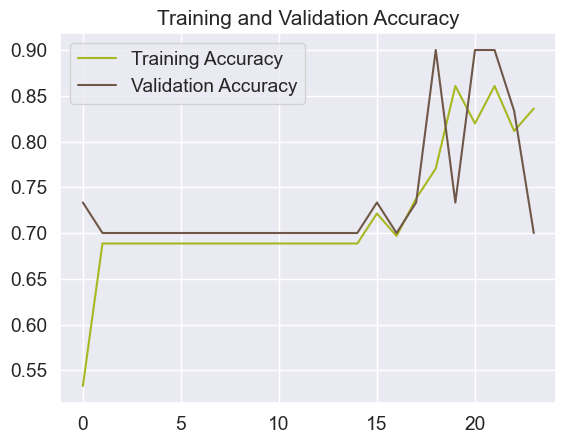

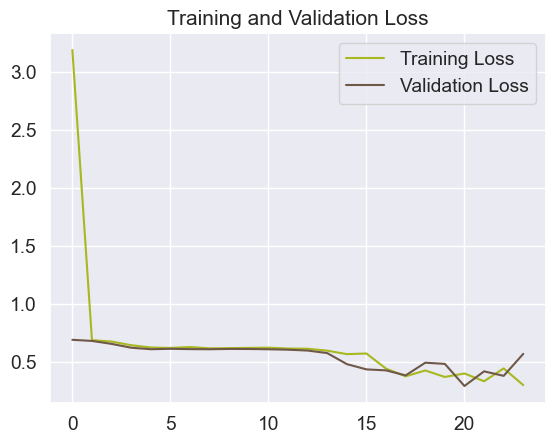

In [31]:
# Get accuracy history on train and testing data
acc = history.history["acc"]
val_acc = history.history["val_acc"]

# Get loss history on train and testin data
loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Get num epochs
epochs = range(len(acc))

# Plot training v.s. test accuracy at each epoch
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Plot training v.s. test loss at each epoch
plt.figure()
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()

## Validation Accuracy

In this section, I use the final model to generate predictions on the validation data, and then visualize which Pokemon the model correctly and incorrectly classifies.

In [38]:
model.load_weights("best_model.h5")

# Get true labels
true_labels = val_data.labels

# Get model predictions
predictions = model.predict(val_data)

# Convert probabilities by thresholding
predictions = [1 if n >= 0.5 else 0 for n in predictions]
print("Model predictions: " + str(predictions))
print("Actual labels:     " + str(true_labels))

# Count num correct and get misclassified filepaths
total = len(true_labels)
num_misclassified = 0
misclassified_filepaths = []
correctness = []
for pred, label, i in zip(predictions, true_labels, range(len(predictions))):
    misclassified_filepaths.append(val_data.filepaths[i])
    if pred != label:
        correctness.append("incorrect")
        num_misclassified += 1
    else:
        correctness.append("correct")

print("# of misclassified pokemon: " + str(num_misclassified))
print("Accuracy: " + str(1 - (num_misclassified / total)))

1/1 [==============================] - 0s 312ms/step
Model predictions: [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0]
Actual labels:     [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
# of misclassified pokemon: 9
Accuracy: 0.7


It is interesting to note that the validation accuracy calculated here does not match the peak of the validation accuracy during the training process of the CNN. This is reasonable and can be due to many reasons. Earlier, we shuffled data in the `train_gen.flow_from_dataframe()` generator. This means that the batch order of the data varies each time we call `model.predict()`, leading to higher or lower accuracies than the peak accuracy in the learning curves.

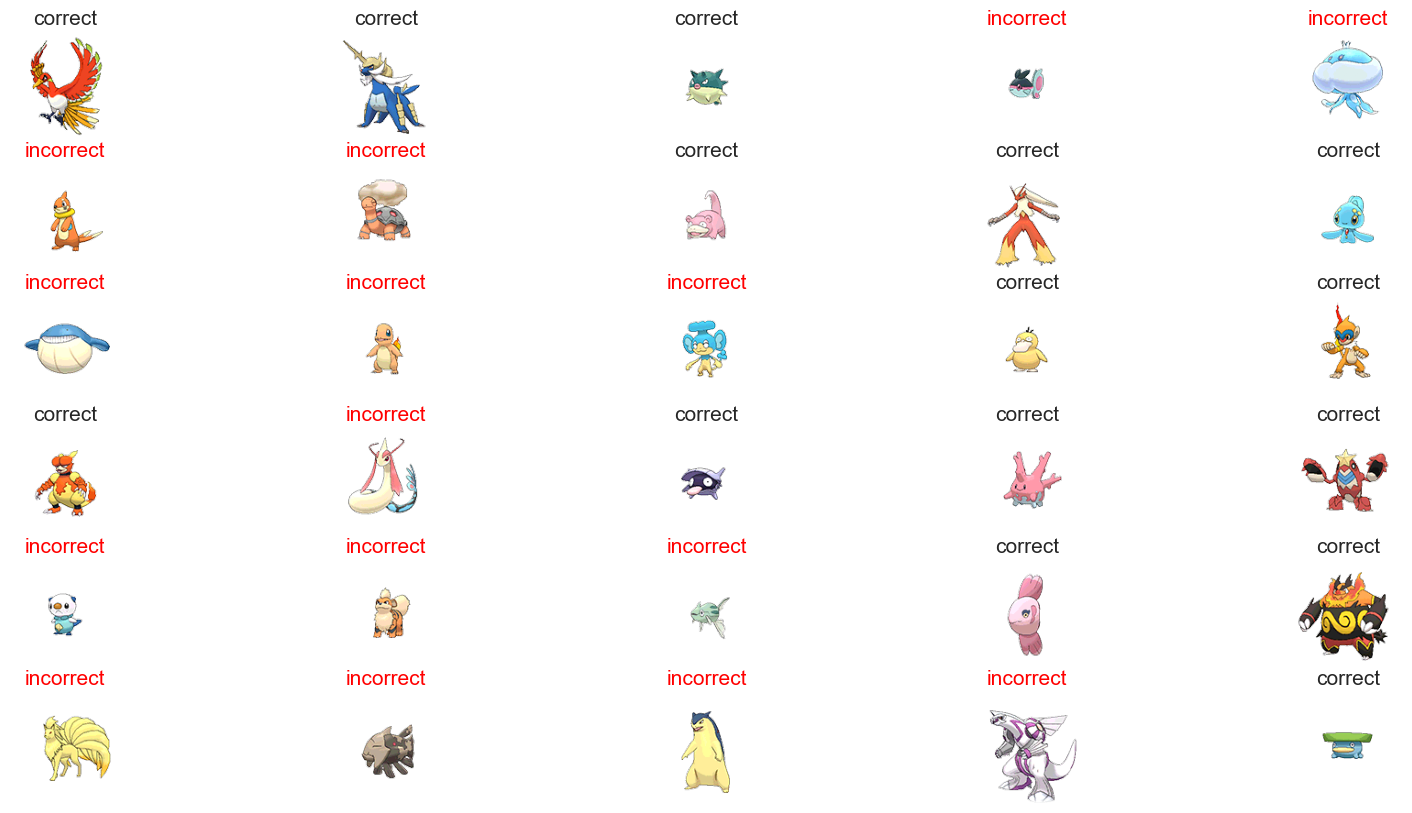

In [19]:
# Obtain images
misclassified_imgs = []
for filepath in misclassified_filepaths:
    misclassified_imgs.append(mpimg.imread(filepath))

# Plot results
f, axarr = plt.subplots(6, 5, figsize=(20, 10))
count = 0
for r in range(6):
    for c in range(5):
        axarr[r, c].imshow(misclassified_imgs[count])
        if correctness[count] == "correct":
            axarr[r, c].set_title(correctness[count])
        else:
            axarr[r, c].set_title(correctness[count], color="red")
        axarr[r, c].set_axis_off()
        count += 1
plt.show()